# 4.0 - Embeddings

In [137]:
#import
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel

import umap
import umap.plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
sns.set_theme()

In [138]:
# read data
df_cleaned = pd.read_parquet('../data/processed/cleaned_data.parquet', engine='pyarrow')

In [ ]:
# exclude articles without topics
""" for index, row in df_cleaned.iterrows():
    if len(row['topics']) == 0:
        df_cleaned.loc[index, 'flag'] = 1
df_cleaned = df_cleaned[~(df_cleaned['flag'] == 1)] """

In [140]:
# setup model
model_name = "nickprock/sentence-bert-base-italian-xxl-uncased"
#model_name = "efederici/sentence-bert-base"
#model_name = "../models/nickprock_fine_tuned"

# enable model on mpu (- Apple Silicon GPU) or cuda (- Nvidia GPU) or cpu if no gpu is available
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)
tokenizer = AutoTokenizer.from_pretrained(model_name) #tokenizer
model = AutoModel.from_pretrained(model_name) #model
model.to(device) # move model to device GPU

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

---

In [68]:
# funtion to calculate the embeddings for each sentence
def sentence_embedding(tokenizer, model, device, sentences_list):
    # initialize list to store sentence embeddings
    sentence_embeddings = []

    for sentences in sentences_list:
        # sentence tokenizer
        encoded_input = tokenizer(sentences, padding = True, truncation = True, return_tensors = "pt")
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

        # model inference
        with torch.no_grad():
            model_output = model(**encoded_input)

        # extract sentence embeddings
        sentence_embedding = model_output.last_hidden_state.mean(dim = 1)
        sentence_embeddings.append(sentence_embedding)

    # average the resulsts to obtain a single embedding for the article
    article_embedding = torch.cat(sentence_embeddings).mean(dim = 0).cpu().numpy()
    
    return article_embedding

# calculate embeddings
df_cleaned['sentence embeddings'] = df_cleaned['text chunked'].apply(
    lambda sentences: sentence_embedding(tokenizer, model, device, sentences)
)

In [71]:
df_cleaned.to_parquet('../data/processed/embeddings_nickproc.parquet', engine = 'pyarrow', index = False)

---

In [72]:
df_cleaned = pd.read_parquet('../data/processed/embeddings_nickproc.parquet', engine = 'pyarrow')

In [73]:
topics = []
for _, row in df_cleaned.iterrows():
    for topic in row['topics']:
        if topic and topic not in topics:
            topics.append(topic)

In [74]:
def topic_embedding(tokenizer, model, topic):
    encoded_input = tokenizer(topic, return_tensors = "pt", padding = True, truncation = True)
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

    # model inference
    with torch.no_grad():
        model_output = model(**encoded_input)

    # embeddings for the topic
    embedding = model_output.last_hidden_state.mean(dim = 1).squeeze().cpu().numpy()
    return embedding

df_topics = pd.DataFrame(topics, columns = ['topic'])
df_topics['embedding'] = df_topics['topic'].apply(lambda topic: topic_embedding(tokenizer, model, topic))

In [75]:
df_topics.rename(columns = {'embedding' : 'sentence embeddings'}, inplace = True)

In [76]:
article_embeddings = np.array(df_cleaned['sentence embeddings'].tolist())
topic_embeddings = np.array(df_topics['sentence embeddings'].tolist())

In [77]:
similarity_matrix = cosine_similarity(article_embeddings, topic_embeddings)

In [78]:
most_similar_topics_indices = similarity_matrix.argmax(axis=1)

In [79]:
most_similar_topics_indices

array([ 8, 22, 13, ..., 17, 25, 22])

In [80]:
df_cleaned['topic'] = df_topics.iloc[most_similar_topics_indices]['topic'].values

In [99]:
df_cleaned['flag topic in topics'] = df_cleaned.apply(lambda row: 1 if row['topic'] in row['topics'] else 0, axis = 1)

In [100]:
round(df_cleaned['flag topic in topics'].sum()/df_cleaned.shape[0], 2), df_cleaned.shape[0]

(0.28, 13670)

In [110]:
# topic non rappresentati
for el in topics:
    if el not in df_cleaned[df_cleaned['flag topic in topics'] == 1]['topic'].unique():
        print(el)

news
guide
uomo
casa
religione


In [118]:
df_cleaned['topic'].value_counts()

topic
oroscopo         2454
gravidanza       1413
alimentazione    1172
malattie         1118
giochi            791
tempo libero      693
bonus             628
feste             627
bambino           624
neonato           599
adozione          452
viaggi            399
mamma             375
istruzione        325
crescita          317
ambiente          272
shopping          231
abbigliamento     208
nomi              197
famiglia          194
lavoro            146
psicologia        132
salute             97
sport              55
video              42
casa               35
animali            34
uomo               21
news                9
guide               7
religione           3
Name: count, dtype: int64

In [130]:
df_cleaned[df_cleaned['flag topic in topics'] == 1]['text chunked'][13]#['topic'].value_counts()

array(['VACCINI OBBLIGATORI E FACOLTATIVI - Vaccinazioni per i neonati e bambini obbligatorie e facoltative, come orientarsi? Quali sono i vaccini che bisogna obbligatoriamente fare ai neonati e quali sono facoltative o raccomandate dal Ministero? Vediamo nel dettaglio il Piano nazionale di prevenzione vaccinale 2012-2014. VACCINAZIONI OBBLIGATORIE - Sono ancora obbligatorie le quattro vaccinazioni contro epatite B, tetano, difterite e poliomielite. VACCINAZIONI RACCOMANDATE - Restano raccomandate le vaccinazioni contro il morbillo, la rosolia e la parotite (vaccino trivalente), e il vaccino contro la pertosse ed Emofilo B (hib). VACCINAZIONI FACOLTATIVE - Nel piano sono state inserite nuove vaccinazioni facoltative dal Ministero: l’antimeningococco e l’antipneumococco contro la meningite e il vaccino anti-Hpv (papilloma virus) per le ragazze dodicenni vengono fortemente consigliate. Vengono inoltre inseriti 3 nuovi vaccini: quello per lo pneumococco coniugato 13 valente (che copre con

In [ ]:
df_cleaned[df_cleaned['topic'] == 'religione']#['text chunked'][7959]

,id,title,publication date,category,post type,domain,url,topics,links words rate,text,text cleaned,text chunked,sentence embeddings,topic,flag topic in topics
2367,Pm_1788,Santa Lucia per i bambini e le tradizioni,2023-11-24,parenting,article,www.pianetamamma.it,https://www.pianetamamma.it/il-bambino/giocare...,"[bambino, crescita]",0.200401,Santa Lucia per i bambini\n\r\n\tLa tradiziona...,"Santa Lucia per i bambini. La tradizionale ""Fe...","[Santa Lucia per i bambini. La tradizionale ""F...","[-0.1183334, 0.5369142, 0.41089436, -1.0848045...",religione,0
7874,Pm_2595961,Perché mandare nostro figlio agli scout? Alla ...,2024-06-05,parenting,article,www.pianetamamma.it,https://www.pianetamamma.it/il-bambino/svilupp...,"[crescita, bambino]",0.489596,Scout\nPiù di 500 milioni di giovani e adulti ...,Scout | Più di 500 milioni di giovani e adulti...,"[Scout, Più di 500 milioni di giovani e adulti...","[-0.15363477, 0.14333153, 0.014893879, -0.4767...",religione,0
7959,Pm_2596156,Quanto è diffuso e cosa vuol dire il nome Tecla?,2024-07-26,parenting,article,www.pianetamamma.it,https://www.pianetamamma.it/nomi/nome-tecla.html,[nomi],2.040816,Nome Tecla: qual è il significato?\nSiete in a...,Nome Tecla: qual è il significato? Siete in at...,[Nome Tecla: qual è il significato? Siete in a...,"[-0.21446185, -0.08901241, 0.15300158, -0.0013...",religione,0


---

In [84]:
df_all = pd.concat([df_cleaned[['id', 'sentence embeddings', 'topic']], df_topics], axis = 0).reset_index(drop = True)

In [85]:
embeddings_matrix = np.array(list(df_all['sentence embeddings']))
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_matrix)

umap_reducer = umap.UMAP(n_components = 3, random_state = 42)
embeddings_reduced = umap_reducer.fit_transform(embeddings_scaled)
embeddings_reduced = umap_reducer.fit_transform(embeddings_matrix)

df_all['embedding reduced'] = list(embeddings_reduced)

/Users/marcomanduca/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/marcomanduca/miniconda3/envs/ai/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/marcomanduca/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [86]:
df_all['umap_x'] = embeddings_reduced[:, 0]
df_all['umap_y'] = embeddings_reduced[:, 1]
df_all['umap_z'] = embeddings_reduced[:, 2]

In [94]:
colors = [
    'gray', 'lightcoral', 'firebrick', 'sienna', 'peru', 'orange',
    'gold', 'khaki', 'yellowgreen', 'greenyellow', 'darkseagreen', 'seagreen',
    'mediumaquamarine', 'darkcyan', 'lightblue', 'dodgerblue', 'slateblue', 'hotpink',
    'plum', 'darkmagenta', 'crimson', 'silver', 'indianred', 'tomato', 'orangered',
    'lemonchiffon', 'darkgoldenrod', 'darkkhaki', 'skyblue', 'lightcyan', 'navy'
]
color_map = {topic: colors[i] for i, topic in enumerate(df_all['topic'].unique())}
#df_all['color'] = df_all['topic'].map(color_map)

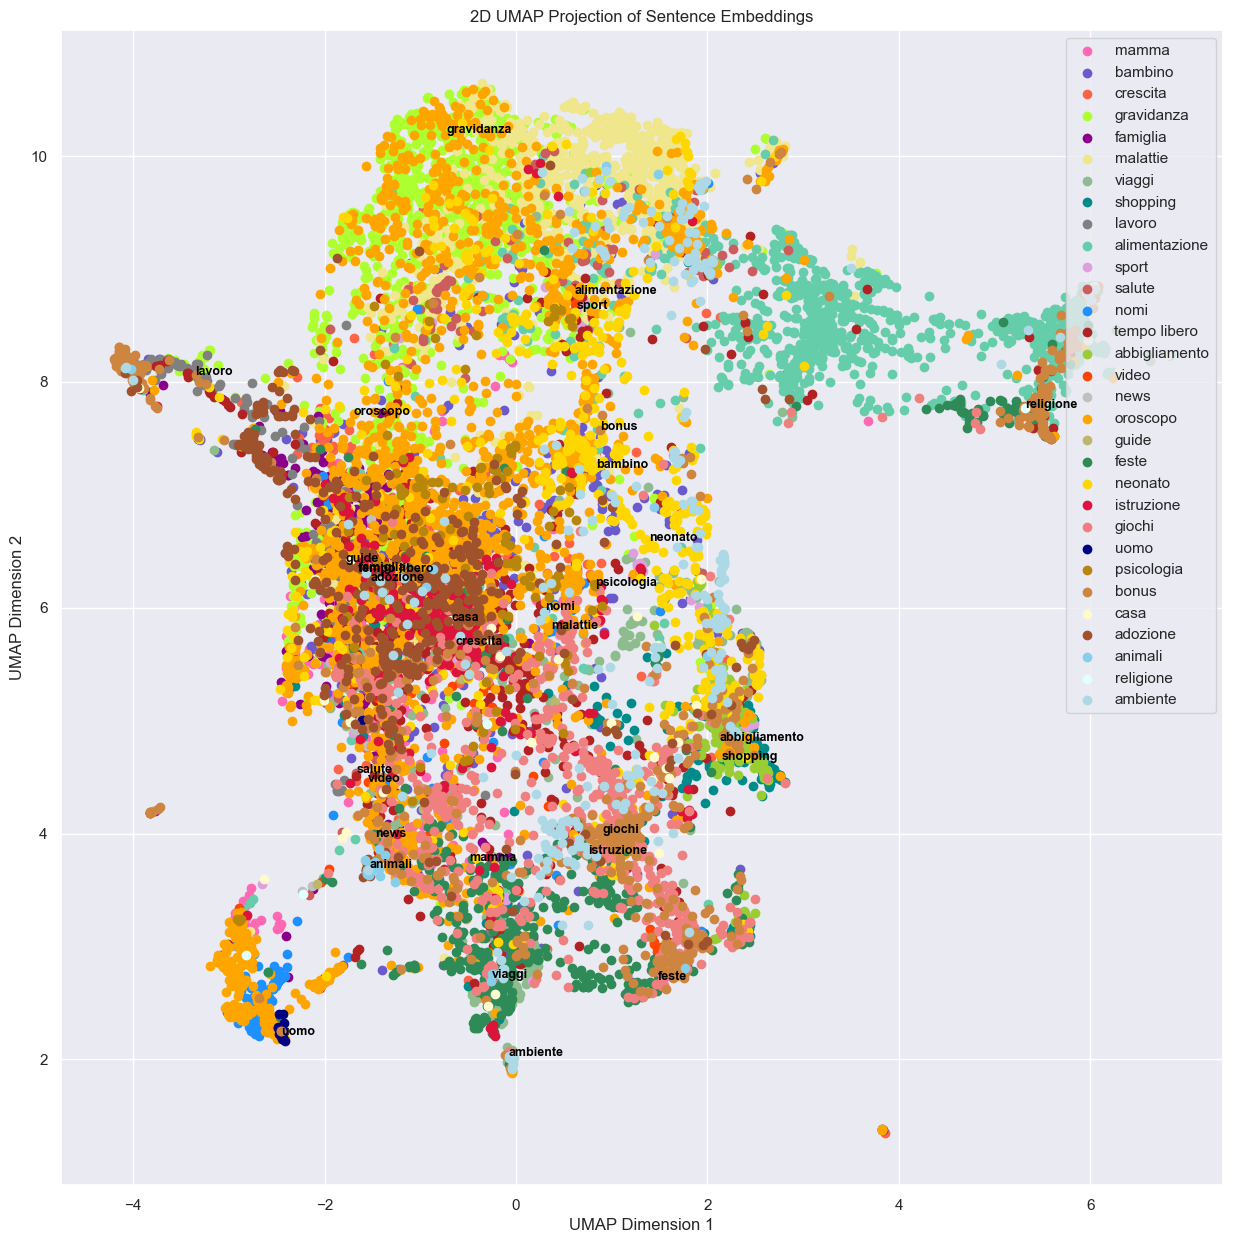

In [95]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

for category in topics:
    indices = df_all['topic'] == category
    ax.scatter(
        df_all.loc[indices, 'umap_x'],
        df_all.loc[indices, 'umap_y'],
        alpha = 1,
        c = color_map[category],
        #c = 'lightseagreen',
        label = category
    )
    x, y = df_all.loc[df_all[df_all['topic'] == category].index[0], ['umap_x', 'umap_y']]
    ax.text(x, y, category, color = 'black', fontsize = 9, weight = 'bold', zorder = 1_000)
""" 
ax.scatter(
    df_all.loc[df_all['topic'] == 'article', 'umap_x'],
    df_all.loc[df_all['topic'] == 'article', 'umap_y'],
    alpha = 0.1,
    c = color_map[category]
    #c = 'lightseagreen',
) """
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.legend(loc = 'upper right')
plt.title('2D UMAP Projection of Sentence Embeddings')
plt.show()

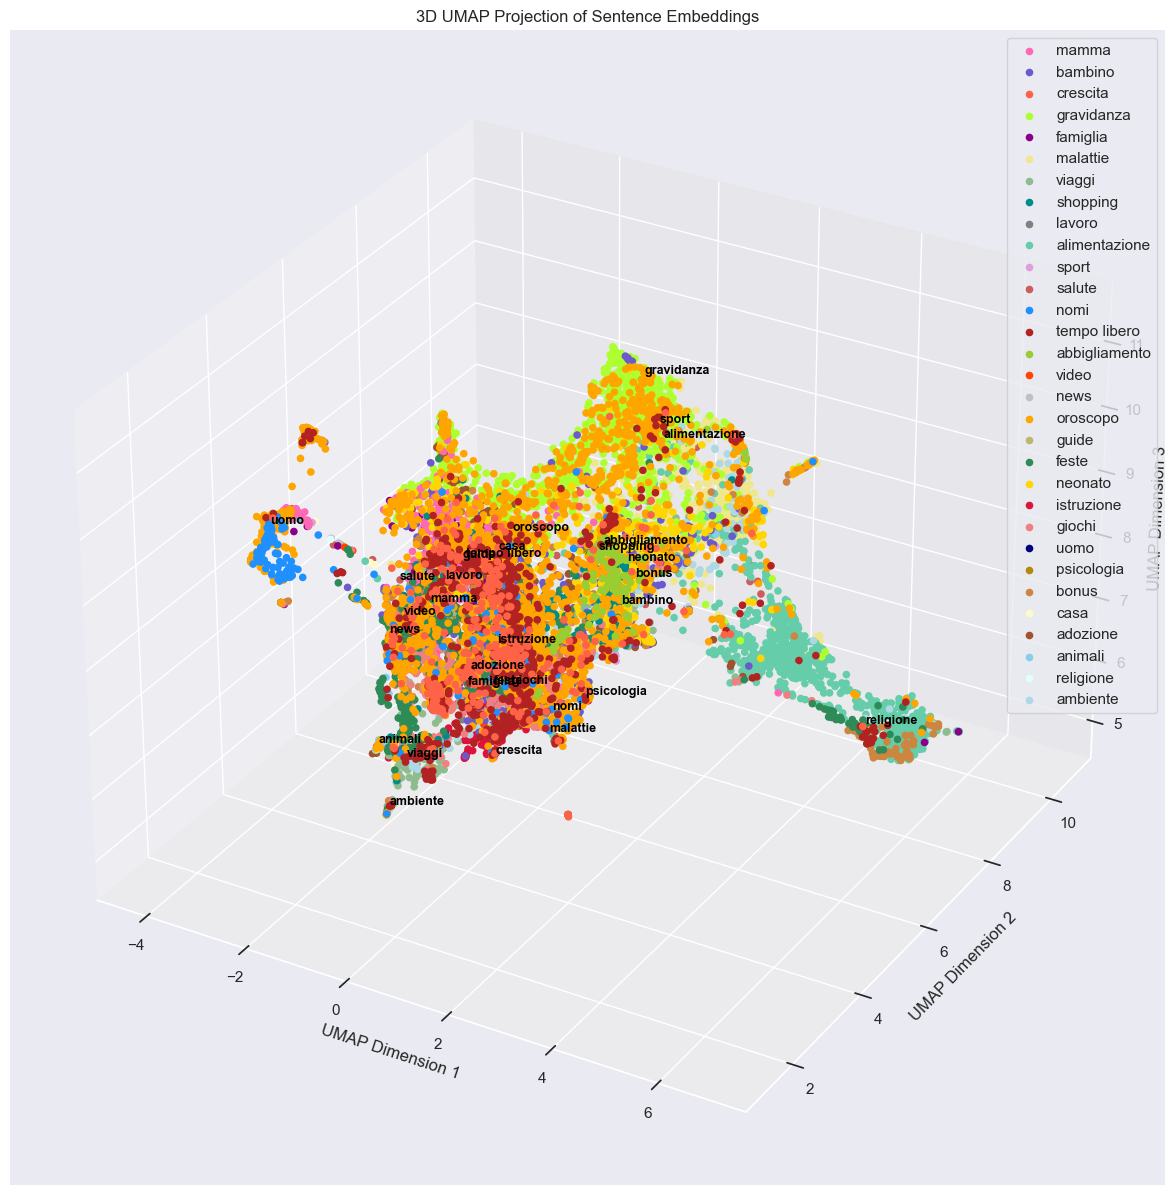

In [96]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')

for category in topics:
    indices = df_all['topic'] == category
    ax.scatter(
        df_all.loc[indices, 'umap_x'],
        df_all.loc[indices, 'umap_y'],
        df_all.loc[indices, 'umap_z'],
        alpha = 1,
        c = color_map[category],
        #c = 'mediumblue',
        label = category
    )
    x, y, z = df_all.loc[df_all[df_all['topic'] == category].index[0], ['umap_x', 'umap_y', 'umap_z']]
    ax.text(x, y, z, category, color = 'black', fontsize = 9, weight = 'bold', zorder = 1_000)
""" 
ax.scatter(
    df_all.loc[df_all['topic'] == 'article', 'umap_x'],
    df_all.loc[df_all['topic'] == 'article', 'umap_y'],
    df_all.loc[df_all['topic'] == 'article', 'umap_z'],
    alpha = 0.1,
    c = 'lightseagreen',
) """
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.legend(loc = 'upper right')
plt.title('3D UMAP Projection of Sentence Embeddings')
plt.show()

In [23]:
df_cleaned = df_cleaned.merge(df_all[['id' ,'embedding reduced', 'umap_x', 'umap_y', 'umap_z']], on = 'id')